In [1]:
import numpy as np
import pandas as pd
from keras.preprocessing import text, sequence
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import EarlyStopping
from keras import backend as K
import tensorflow as tf

Using TensorFlow backend.


In [2]:
''' Loading input data ''' 
def seq2ngrams(seqs, n = 3):
    return np.array([[seq[i : i + n] for i in range(len(seq))] for seq in seqs])

train_df = pd.read_csv('../../train_input.csv')
test_df = pd.read_csv('../../test_input.csv')

# Find maximum length sequence
num_train = len(train_df)
num_test = len(test_df)
maxlen_seq = max(train_df['length'].values.max(), test_df['length'].values.max())

# Loading and converting the inputs to ngrams
train_input_aa, train_input_q8 = train_df[['sequence', 'q8']].values.T
train_aa_grams = seq2ngrams(train_input_aa, n=3)
train_q8_grams = seq2ngrams(train_input_q8, n=3)

test_input_aa, test_input_q8 = test_df[['sequence', 'q8']].values.T
test_aa_grams = seq2ngrams(test_input_aa, n=3)
test_q8_grams = seq2ngrams(test_input_q8, n=3)

# Initializing and defining the tokenizer encoders based on the train set
tokenizer_encoder_aa = Tokenizer()
tokenizer_encoder_aa.fit_on_texts(train_aa_grams)
tokenizer_encoder_q8 = Tokenizer()
tokenizer_encoder_q8.fit_on_texts(train_q8_grams)

# Using the tokenizer to encode the input sequences for use in training and testing
train_input_aa = tokenizer_encoder_aa.texts_to_sequences(train_aa_grams)
train_input_aa = sequence.pad_sequences(train_input_aa, maxlen = maxlen_seq, padding = 'post', truncating='post')
train_input_q8 = tokenizer_encoder_q8.texts_to_sequences(train_q8_grams)
train_input_q8 = sequence.pad_sequences(train_input_q8, maxlen = maxlen_seq, padding = 'post', truncating='post')

test_input_aa = tokenizer_encoder_aa.texts_to_sequences(test_aa_grams)
test_input_aa = sequence.pad_sequences(test_input_aa, maxlen = maxlen_seq, padding = 'post', truncating='post')
test_input_q8 = tokenizer_encoder_q8.texts_to_sequences(test_q8_grams)
test_input_q8 = sequence.pad_sequences(test_input_q8, maxlen = maxlen_seq, padding = 'post', truncating='post')

n_words_aa = len(tokenizer_encoder_aa.word_index) + 1
n_words_q8 = len(tokenizer_encoder_q8.word_index) + 1

In [3]:
''' Loading training target data '''
train_target_arrs = np.load('../../train_output.npz')

seq_len = train_df['length'].values
train_target_data = np.zeros((num_train, maxlen_seq, maxlen_seq))
for i in range(num_train):
    train_target_data[i, :seq_len[i], :seq_len[i]] = train_target_arrs['arr_' + str(i)]

train_target_data_flat = np.zeros((num_train, int(maxlen_seq*(maxlen_seq-1)/2))) #n*(n-1)/2
for i in range(num_train):
    len_seq = seq_len[i]
    tri_idx = np.triu_indices(len_seq, 1)
    train_target_data_flat[i, :int(len_seq*(len_seq-1)/2)] = train_target_data[i, :len_seq, :len_seq][tri_idx]

In [87]:
# Define custom distance layer for making predictions
class Distance(Layer):
    def __init__(self, **kwargs):
        super(Distance, self).__init__(**kwargs)

    def build(self, input_shape):
        super(Distance, self).build(input_shape)

    def call(self, x):
        r = tf.reduce_sum(x*x, 2)
        r = tf.expand_dims(r, -1)
        xx = tf.einsum('bij,bjk->bik', x, tf.linalg.transpose(x))
        D = r - 2*xx + tf.linalg.transpose(r)
        return D
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1], input_shape[1]) 
    
class Symmetrize(Layer):
    def __init__(self, **kwargs):
        super(Symmetrize, self).__init__(**kwargs)

    def build(self, input_shape):
        super(Symmetrize, self).build(input_shape)

    def call(self, x):
        x = (x+tf.linalg.transpose(x))/2
        return x
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1], input_shape[1]) 

class Pairwise(Layer):
    def __init__(self, **kwargs):
        super(Pairwise, self).__init__(**kwargs)

    def build(self, input_shape):
        super(Pairwise, self).build(input_shape)

    def call(self, x):
        idx1, idx2 = np.triu_indices(maxlen_seq)
        idx = (maxlen_seq*idx1+idx2)[np.where(idx1-idx2!=0)]
        
        x1 = K.expand_dims(x, 1)
        x2 = K.expand_dims(x, 2)
        x1 = Lambda(lambda x: K.repeat_elements(x, maxlen_seq, axis=1))(x1)
        x2 = Lambda(lambda x: K.repeat_elements(x, maxlen_seq, axis=2))(x2)
        x_ = Concatenate()([x1, x2])
        x_ = Reshape([maxlen_seq*maxlen_seq, 2304])(x_)
        x_ = tf.gather(x_, indices=idx, axis=1)
        return x_

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1]*(input_shape[1]-1)/2, 2*input_shape[2])
    

def model4(emb):
    def conv(x, filter_size):
        x = ZeroPadding2D((filter_size//2, 0), data_format='channels_first')(x)
        x = Conv2D(filters=64, kernel_size=(filter_size, 128), data_format='channels_first', activation='relu')(x)
        x = BatchNormalization(momentum=0.9)(x)
        return x

    emb = Reshape([1, maxlen_seq, 128])(emb)

    # Defining 3 convolutional layers with different kernel sizes
    conv1 = conv(emb, 3)
    conv2 = conv(emb, 7)
    conv3 = conv(emb, 11)
    conv_ = Concatenate(-1)([conv1, conv2, conv3])
    conv_ = Permute((2, 1, 3))(conv_)
    conv_ = Reshape([maxlen_seq, 3*64])(conv_)

    # Defining 3 bidirectional GRU layers; taking the concatenation of outputs 
    gru1 = Bidirectional(GRU(64, return_sequences='True', recurrent_dropout=0.1))(conv_)
    gru2 = Bidirectional(GRU(64, return_sequences='True', recurrent_dropout=0.1))(gru1)
    gru3 = Bidirectional(GRU(64, return_sequences='True', recurrent_dropout=0.1))(gru2)
    comb = Concatenate(-1)([gru1, gru2, gru3, conv_])    
    return comb

def get_model(num):
    # Embedding inputs
    input_aa = Input(shape = (maxlen_seq, ))
    input_q8 = Input(shape = (maxlen_seq, ))

    embed_aa = Embedding(input_dim = n_words_aa, output_dim = 128, input_length = maxlen_seq)(input_aa)
    embed_q8 = Embedding(input_dim = n_words_q8, output_dim = 128, input_length = maxlen_seq)(input_q8)
    
    if num == 2:
        aa = model2(embed_aa)
        q8 = model2(embed_q8)
    elif num == 4:
        aa = model4(embed_aa)
        q8 = model4(embed_q8)
    
    # concatenate features and then impose pairwise constraints
    x = Concatenate(-1)([aa, q8]) 
    x = Pairwise()(x)

    # Some final fully connected layers before distance calculation
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.1)(x)
    y = Dense(1, use_bias=False)(x)
    
    # Defining the model as a whole and printing the summary
    return Model([input_aa, input_q8], y)

In [88]:
model = get_model(4)
model.summary()

(?, 238395, 2304)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_69 (InputLayer)           (None, 691)          0                                            
__________________________________________________________________________________________________
input_70 (InputLayer)           (None, 691)          0                                            
__________________________________________________________________________________________________
embedding_69 (Embedding)        (None, 691, 128)     1225472     input_69[0][0]                   
__________________________________________________________________________________________________
embedding_70 (Embedding)        (None, 691, 128)     34688       input_70[0][0]                   
___________________________________________________________________________________________

In [ ]:
model.compile(optimizer = 'nadam', loss = 'mean_squared_error')

train_aa = train_input_aa[:10]
val_aa = train_input_aa[10:20]

train_q8 = train_input_q8[:10]
val_q8 = train_input_q8[10:20]

train_tar = train_target_data[:10]
val_tar = train_target_data[10:20]

model.fit([train_aa, train_q8], train_tar, 
          batch_size = 10, epochs = 50, 
          validation_data = ([val_aa, val_q8], val_tar), 
          callbacks = [EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)],
          verbose = 1)

In [ ]:
''' save model '''
model.save('seq2mat_4.h5')
model.save_weights('seq2mat_4_weights.h5')

In [56]:
''' Testing '''
model = load_model('models/seq2mat_8.h5', custom_objects={'Symmetrize':Symmetrize})
pred = model.predict([test_input_aa, test_input_q8])

In [57]:
pred = model.predict([test_input_aa, test_input_q8])
out = []
for i in range(len(pred)):
    l = test_df['length'][i]
    pred_ = pred[i, :l, :l]
    out.append(pred_)
np.savez('predictions/test8.npz', *out)

BIG CHANGES:
    Predict n(n-1)/2 not n^2
    PyBLAST: Homology. Find training example sequences closest to the sequences in the test example.
        Use secondary structure to place these patches
    GAN to fill in missing data (Namarta Anand)  
    
    Try good predictor of the average (autoML in SciKitLearn)
        Then extend to row or column
        Then extend to matrix
        
        Could offset our results by those mean
        
        Switch to plotting fixed values not normalized (use plasma)
        
    CANNOT find a function without checking the range of a function and first momentsstage

In [ ]:
''' Predictions '''
pred = model.predict([test_input_aa, test_input_q8])
# saving
out = []
for i in range(len(pred)):
    l = test_df['length'][i]
    pred_ = pred[i, :l, :l]
    out.append(pred_)
np.savez('test8.npz', *out)

(array([2.03312780e+09, 1.23339476e+08, 1.63010100e+07, 1.35788800e+06,
        2.08382000e+05, 6.13360000e+04, 2.81360000e+04, 1.61740000e+04,
        7.20400000e+03, 1.06400000e+03]),
 array([  0.        ,  23.84976196,  47.69952393,  71.54928589,
         95.39904785, 119.24880981, 143.09857178, 166.94833374,
        190.7980957 , 214.64785767, 238.49761963]),
 <a list of 10 Patch objects>)

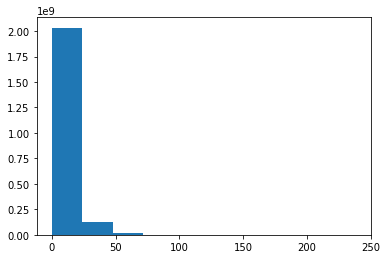

In [8]:
import matplotlib.pyplot as plt
plt.hist(train_target_data.ravel())

In [7]:
plt.show()